In [1]:
from torchvision.models import *
import wandb
from sklearn.model_selection import train_test_split
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import *
import torch,torchvision
from tqdm import tqdm
device = 'cuda'
PROJECT_NAME = 'Shapes-Clf'

In [2]:
def load_data():
    labels = {}
    data = []
    labels_r = {}
    idx = 0
    for folder in os.listdir('./data/'):
        idx += 1
        labels[folder] = idx
        labels_r[idx] = folder
    for folder in tqdm(os.listdir('./data/')):
#         print(folder)
        for file in os.listdir(f'./data/{folder}/'):
            img = cv2.imread(f'./data/{folder}/{file}')
            img = cv2.resize(img,(112,112))
            img = img / 255.0
            data.append([img,np.eye(labels[folder],len(labels))[labels[folder]-1]])
    X = []
    y = []
    for d in data:
        X.append(d[0])
        y.append(d[1])
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
    X_train = torch.from_numpy(np.array(X_train)).to(device).view(-1,3,112,112).float()
    y_train = torch.from_numpy(np.array(y_train)).to(device).float()
    X_test = torch.from_numpy(np.array(X_test)).to(device).view(-1,3,112,112).float()
    y_test = torch.from_numpy(np.array(y_test)).to(device).float()
    return X,y,X_train,X_test,y_train,y_test,labels,labels_r,idx,data

In [3]:
X,y,X_train,X_test,y_train,y_test,labels,labels_r,idx,data = load_data()

100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.24s/it]


In [4]:
torch.save(X_train,'X_train.pt')
torch.save(y_train,'y_train.pt')
torch.save(X_test,'X_test.pt')
torch.save(y_test,'y_test.pt')
torch.save(labels_r,'labels_r.pt')
torch.save(labels,'labels.pt')

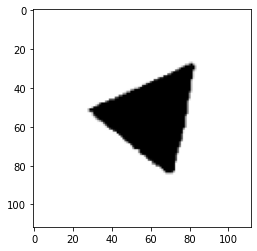

In [5]:
plt.imshow(X_train[0].view(112,112,3).cpu())

In [6]:
labels_r[int(torch.argmax(y_train[0]))+1]

'triangle'

In [7]:
def get_loss(model,X,y,criterion):
    preds = model(X)
    loss = criterion(preds,y)
    return loss.item()

In [8]:
def get_accuracy(model,X,y):
    preds = model(X)
    correct = 0
    total = 0
    for pred,y_batch in zip(preds,y):
        preds = int(torch.argmax(pred))
        y_batch = int(torch.argmax(y_batch))
        if pred == y_batch:
            correct += 1
        total += 1
    acc = round(correct/total,3)*100
    return acc

In [16]:
class Model(Module):
    def __init__(self):
        super().__init__()
        self.activation = ReLU()
        self.max_pool2d = MaxPool2d((2,2),(2,2))
        self.conv1 = Conv2d(3,7,(5,5))
        self.conv1bn = BatchNorm2d(7)
        self.conv2 = Conv2d(7,14,(5,5))
        self.conv2bn = BatchNorm2d(14)
        self.conv3 = Conv2d(14,21,(5,5))
        self.conv3bn = BatchNorm2d(21)
        self.linear1 = Linear(2100,256)
        self.linear1bn = BatchNorm1d(256)
        self.linear2 = Linear(256,512)
        self.linear2bn = BatchNorm1d(512)
        self.linear3 = Linear(512,256)
        self.linear3bn = BatchNorm1d(256)
        self.output = Linear(256,len(labels))
    
    def forward(self,X):
        preds = self.max_pool2d(self.activation(self.conv1bn(self.conv1(X))))
        preds = self.max_pool2d(self.activation(self.conv2bn(self.conv2(preds))))
        preds = self.max_pool2d(self.activation(self.conv3bn(self.conv3(preds))))
#         print(preds.shape)
        preds = preds.view(-1,2100)
        preds = self.activation(self.linear1bn(self.linear1(preds)))
        preds = self.activation(self.linear2bn(self.linear2(preds)))
        preds = self.activation(self.linear3bn(self.linear3(preds)))
        preds = self.output(preds)
        return preds

In [17]:
model = Model().to(device)
criterion = MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 100
batch_size = 32

In [18]:
wandb.init(project=PROJECT_NAME,name='baseline')
wandb.watch(model)
for _ in tqdm(range(epochs)):
    wandb.watch(model)
    for i in range(0,len(X_train),batch_size):
        torch.cuda.empty_cache()
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    wandb.log({'Loss':(get_loss(model,X_train,y_train,criterion)+get_loss(model,X_batch,y_batch,criterion))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val Loss':get_loss(model,X_test,y_test,criterion)})
    torch.cuda.empty_cache()
    wandb.log({'Acc':(get_accuracy(model,X_train,y_train)+get_accuracy(model,X_batch,y_batch))/2})
    torch.cuda.empty_cache()
    wandb.log({'Val ACC':get_accuracy(model,X_test,y_test)})
    torch.cuda.empty_cache()
    wandb.watch(model)
wandb.watch(model)
wandb.finish()

  0%|                                                   | 0/100 [00:00<?, ?it/s]

torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32

  0%|                                                   | 0/100 [00:02<?, ?it/s]

torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([32, 21, 10, 10])
torch.Size([27, 21, 10, 10])


RuntimeError: CUDA out of memory. Tried to allocate 3.42 GiB (GPU 0; 11.77 GiB total capacity; 5.63 GiB already allocated; 1.93 GiB free; 8.15 GiB reserved in total by PyTorch)

Process wandb_internal:
Traceback (most recent call last):
  File "/home/indika/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/indika/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/indika/anaconda3/lib/python3.7/site-packages/wandb/sdk/internal/internal.py", line 152, in wandb_internal
    thread.join()
  File "/home/indika/anaconda3/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/home/indika/anaconda3/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt
